# Transformation database
De dataset is voorlopig onbruikbaar voor training door de veelheid aan Null values. In de gedeelde brainstormsessie zijn Ali en ik op een volgende structuur gekomen
(Afbeelding)
Hieronder staat de code voor de structuur

## Acceptatiecriteria
- Nieuwe dataset heeft geen duplicaten
- Datamigratie is getest met test database
- Code heeft tussentijdse berichten van waar fouten kunnen ontstaan
- Alle gegevens zijn Volledig en Correct overgezet

## Kwaliteitscriteria
- Data is getest op volledigheid (Aantal rijen komt overeen met aantal starts) (Betrouwbaarheid/ validatie)
- Data is correct overgezet (Berekeningen van time spent kloppen) (Betrouwbaarheid/ validatie)
- Geen redunantie in de data (betrouwbaarheid/ validatie)
- Overzichtelijke indeling (bruikbaarheid)

# Code

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#importeer ontvangen dataset
df = pd.read_csv('cleaned_gmt_data.csv')
#df = pd.read_csv('./cleaned_waariskarmandata.csv')
#df = pd.read_csv('./testdata.csv')

#controleer datatypen
df['log'] = pd.to_datetime(df['log'], errors='coerce')
df['correctAnswer'] = df['correctAnswer'].astype(bool)

#df = pd.read_csv('./test_data.csv')
print ("dataset is ingeladen")

C:\Users\alecv\AppData\Local\Temp\ipykernel_91780\594991828.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['log'] = pd.to_datetime(df['log'], errors='coerce')


dataset is ingeladen


# Korte analyse van ingeladen data

In [2]:
#Overzicht van aantal unieke waarden in database
print(df.nunique())

user_id            34
session_id       1034
log                 0
action            146
timeTaken        3996
correctAnswer       2
dtype: int64


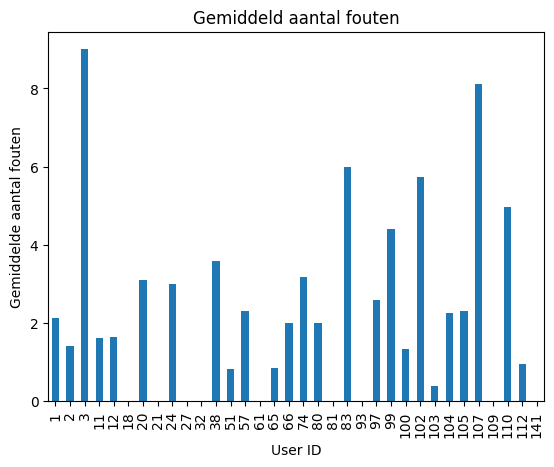

In [12]:
# Gemiddelde timeTaken per user berekenen
true_counts = df.groupby('user_id')['correctAnswer'].sum()

session_counts = df.groupby('user_id')['session_id'].nunique()

avg_errors_per_session = true_counts/ session_counts

# Barchart plotten
overall_avg = avg_errors_per_session.mean()
avg_errors_per_session.plot(kind='bar')

plt.title('Gemiddeld aantal fouten')
plt.xlabel('User ID')
plt.ylabel('Gemiddelde aantal fouten')
plt.show()

## Groepeer door de verschillende rows
Het spel staat acties op dezelfde chronologische volgorde op. Dit houdt in dat het spel altijd start met een "start", en eindigd met een "Game_end'.

### Eerste poging
Ik probeerde deze poging een "Dynamische selectie" te maken, hiermee probeerde ik de verschillende categoriën te baseren op de positie wanneer ze in de database voorkomen. Echter blijkt dit gebaseerd op de eerste paar sessies, waardoor deze manier niet mogelijk is, en dus hard gecodeerd moet worden

! Wordt niet gebruikt

# Groeperen in overkoepelende categoriën
Deze categoriën zijn hard-coded. Nieuw geïntroduceerde waarden moeten handmatig worden geintroduceerd, deze worden eerst in de "overige" categorie geplaatst.

In [ ]:
#DOEL; doel selecteren + centrale keuzescherm(hub) waarbij speler doel of spel kiest
doel = ['doel_start', 'doel_fout', 'doel_goed', 'doel_klaar', 'doel_herhaalstart', 'doel_herhaalklaar','hub_start', 'hub_klaar', 'hub_fout',]

#STAPPEN: Uit te voeren stappen
stappen = ['stappen_uitlegstart', 'stappen_uitlegklaar', 'stappen_start', 'stappen_goed', "stappen_fout" ,'stappen_klaar', 'stappen_herhaalstart', 'stappen_herhaalklaar' "ui_stappen_open" , "ui_stappen_close"]

#LEER: leer welke stappen je uit moet voeren + hoe te hanteren
leer = ['voorkomen_start', 'voorkomen_fout', 'voorkomen_goed', 'voorkomen_klaar', 'ui_stappen_open', 'ui_stappen_close', 'intro_klaar',]

#UITVOEREN: uitvoeren van de verschillende stappen van het spel (objecten "hanteren", planeten selecteren en juiste pinnen)
uitvoeren = ['hanteren_fout', 'hanteren_start', 'hanteren_goed', 'hanteren_klaar', 'planeten_start', 'planeten_goed', 'planeten_klaar','pin_start', 'pin_goed', 'pin_klaar', 'pin_fout']

#Overige ongebruikte categoriën
uitleg = ['start']
tijdsdruk = ['tijdsdruk_start', 'tijdsdruk_fout', 'tijdsdruk_goed', 'tijdsdruk_klaar']

balonnen = ['gesprek_start', 'gesprek_ballon_1', 'gesprek_ballon_2', 'gesprek_ballon_3', 'gesprek_ballon_4', 'gesprek_ballon_5', 'gesprek_ballon_6', 'gesprek_ballon_7', 'gesprek_ballon_8', 'gesprek_ballon_9', 'gesprek_ballon_10', 'gesprek_ballon_11', 'gesprek_ballon_12', 'gesprek_ballon_13', 'gesprek_ballon_14', 'gesprek_ballon_15', 'gesprek_ballon_16', 'gesprek_ballon_17', 'gesprek_ballon_18', 'gesprek_ballon_19', 'gesprek_ballon_20', 'gesprek_ballon_21', 'gesprek_klaar']
finish = ["game_klaar", 'game_end']
overig = []

#In onderstaande stap worden de categorieën samengevoegd in een dictionary
categorie_dict = {
    "doel": doel,
    "stappen": stappen,
    "leer": leer,
    "uitvoeren": uitvoeren,
    "tijdsdruk": tijdsdruk,
    "balonnen": balonnen,
    'finish': finish,
    "overig": overig
}

rows = [(action, cat) for cat, actions in categorie_dict.items() for action in actions]

df_actions = pd.DataFrame(rows, columns=['action', 'category']) 

In [ ]:
#Deze code genereerd een nieuwe lege sessie voor in de database
def new_session(id,user,log):
    return {
        "session_id":id,
        "user_id":user,
        "log":log,
        "finished": False,
        "total_fout": 0,
        "total_goed": 0,
        "total_time":0.0,
        "total_actions":0,
        }

In [ ]:
#Het aanmaken van de eerste dataframe voor de nieuwe sessies
rearranged_session_df = pd.DataFrame(columns=["user_id","session_id","log","total_time","total_actions","finished"])

#Vorige sessie bijhouden om daar later mee te vergelijken
prev_session_id = None
current_session = {}

#Itereer door de verschillende logs
# _ zorgt voor dat het meteen een bruikbaar item word
for _ ,log in df.iterrows():
    session_id = log['session_id']

    #controleer of we nu in dezelfde sessie zitten als de vorige iteratie
    if (session_id != prev_session_id):
        #push de vorige sessie naar de nieuwe dataframe
        if prev_session_id is not None:
            rearranged_session_df = pd.concat(
                [rearranged_session_df, pd.DataFrame([current_session])],
                ignore_index=True
            )
            current_session = {}

        #verander het vorige sessie id
        prev_session_id = session_id
        user = log['user_id']
        log_id = log['log']
        current_session = new_session(session_id,user,log_id)
    else:
        row = df_actions.loc[df_actions["action"] == log["action"], "category"]
        if not row.empty:
            categorie = row.iloc[0]
        else:
            categorie = "overig"
            #print(categorie, " is niet bestaand")

        #Hier moet ook een aparte fout counter komen
        if categorie == "finish":
            current_session['finished'] = True
        else:    
            #voeg de log toe aan de huidige sessie
            time_taken_name = categorie+'_time_taken'
            stappen_name = categorie+'_stappen_completed'
            fouten_name = categorie+'_fouten'
            goed_name = categorie+'_goed'
            afgerond_name = categorie+'_afgerond'

            # Maakt een nieuwe colom aan als een rij niet bestaat, is in het teken van dynamic coding
            if time_taken_name not in current_session:
                current_session[time_taken_name] = 0.0
            if stappen_name not in current_session:
                current_session[stappen_name] = 0
            if fouten_name not in current_session:
                current_session[fouten_name] = 0
            if goed_name not in current_session:
                current_session[goed_name] = 0
            if afgerond_name not in current_session:
                current_session[afgerond_name] = False


            current_session[time_taken_name] += log['timeTaken']
            current_session[stappen_name] += 1
            if log['action'].endswith('_fout'):
                current_session[fouten_name] += 1
                current_session['total_fout'] +=1
            if log['action'].endswith('_goed'):
                current_session[goed_name] += 1
                current_session['total_goed'] +=1
            if log['action'].endswith('_klaar'):
                current_session[afgerond_name] = True
                
        current_session['total_time'] += log['timeTaken']
        current_session['total_actions'] += 1
#pushed de laatste rij       
rearranged_session_df = pd.concat(
                [rearranged_session_df, pd.DataFrame([current_session])],
                ignore_index=True
            )

print("Data is omgezet")
rearranged_session_df.to_csv('gmt_session_data.csv', index=False)
print("Data is geëxpoorteerd")

C:\Users\alecv\AppData\Local\Temp\ipykernel_91780\4123312821.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rearranged_session_df = pd.concat(


Data is omgezet
Data is geëxpoorteerd


In [ ]:
# Handmatige controle of alles klopt, hierbij is het aantal kolomen maximaal zichtbaar
pd.set_option('display.max_columns', None)
print(rearranged_session_df.head(5))

  user_id                            session_id  log  total_time  \
0       1  4dac0e93-d7ed-4bbe-9b0b-0c3b1d53af49  NaN      207.74   
1       1  84826ff2-68ab-45bc-aa53-02e2ca0a5eff  NaN       50.94   
2       1  787d1762-089c-4e39-81fd-dd0422aa408d  NaN      264.22   
3       1  8a91a808-51f3-46dd-bc1a-242e3d0096a8  NaN      361.93   
4       1  f693a273-716c-460c-bd3a-da9b112c11e0  NaN      243.01   

  total_actions finished  total_fout  total_goed  doel_time_taken  \
0            33    False         5.0         7.0            60.85   
1            10    False         2.0         3.0            20.90   
2             3    False         2.0         0.0           264.22   
3            13     True         0.0         4.0           120.77   
4            13     True         0.0         4.0            86.14   

   doel_stappen_completed  doel_fouten  doel_goed doel_afgerond  \
0                     8.0          2.0        1.0          True   
1                     3.0          0.0    

## Samenvoegen van sessies per gebruiker
Hieronder staat de code voor het groeperen van de sessies per gebruiker. Er worden bij het maken van deze variabalen veel extra nieuwe waarden aangemaakt, deze worden gebruikt om later ratio's mee te berekenen

In [ ]:
# ---- Sessie informatie ----
# Veranderen van finished boolean naar integer voor makkelijke sommen
rearranged_session_df['total_sessions'] = 1 #Dit is een doordat het telkens wordt opgeteld
rearranged_session_df['aantal_afgerond'] = rearranged_session_df['finished'].astype(int)
rearranged_session_df['aantal_niet_afgerond'] = (rearranged_session_df['finished'] !=True).astype(int)

# ---- Fouten ----
# berekenen van ratio fout tegenover totaal uitgevoerde stappen 1 = foutloos , 0 = overal fouten gemaakt, -1 is gestopt bij onvoltooide spellen
# als je 0 goede antwoorden heb, wordt er een -1 teruggegeven
rearranged_session_df['ratio_fout'] = np.where(
    rearranged_session_df['total_goed'] == 0,
    np.nan,
    (rearranged_session_df['total_fout'] / (rearranged_session_df['total_goed'])-rearranged_session_df['total_fout'])
)

# ---- Sessietijden ----
# Scheiden van totale tijd, en de tijd van de afgeronde sessies.
rearranged_session_df['total_time_finished_sessions'] = rearranged_session_df['total_time'].where(
    rearranged_session_df['finished'], 0
    )

rearranged_session_df['total_time_unfinished_sessions'] = rearranged_session_df['total_time'].where(
    rearranged_session_df['finished'] !=True, 0
)
rearranged_session_df['avg_step_time'] = (
    rearranged_session_df['total_time'] /
    rearranged_session_df['total_actions'].replace(0, np.nan)
)
# ---- Prestatievariabelen ----
# Waarde is verwijderd doordat het een te grote invloed had op het totaal
#rearranged_session_df['efficiency'] = rearranged_session_df['total_actions'] / rearranged_session_df['total_time'].replace(0, np.nan)

# ------ Spelvariabelen -----
rearranged_session_df['doel_fouten_ratio'] = np.where(
    rearranged_session_df['doel_goed'] == 0,
    np.nan,
    (rearranged_session_df['doel_fouten'] / (rearranged_session_df['doel_goed'])-rearranged_session_df['doel_fouten'])
)
rearranged_session_df['stappen_fouten_ratio'] = np.where(
    rearranged_session_df['stappen_goed'] == 0,
    np.nan,
    (rearranged_session_df['stappen_fouten'] / (rearranged_session_df['stappen_goed'])-rearranged_session_df['stappen_fouten'])
)
rearranged_session_df['leer_fouten_ratio'] = np.where(
    rearranged_session_df['leer_goed'] == 0,
    np.nan,
    (rearranged_session_df['leer_fouten'] / (rearranged_session_df['leer_goed'])-rearranged_session_df['leer_fouten'])
)
rearranged_session_df['uitvoeren_fouten_ratio'] = np.where(
    rearranged_session_df['uitvoeren_goed'] == 0,
    np.nan,
    (rearranged_session_df['uitvoeren_fouten'] / (rearranged_session_df['uitvoeren_goed'])-rearranged_session_df['uitvoeren_fouten'])
)

# Gemiddelde tijd per stap berekenen
rearranged_session_df['avg_doel_step_time'] = (
    rearranged_session_df['doel_time_taken'] /
    rearranged_session_df['doel_stappen_completed'].replace(0, np.nan)
)
rearranged_session_df['avg_stappen_step_time'] = (
    rearranged_session_df['stappen_time_taken'] /
    rearranged_session_df['stappen_stappen_completed'].replace(0, np.nan)
)
rearranged_session_df['avg_leer_step_time'] = (
    rearranged_session_df['leer_time_taken'] /
    rearranged_session_df['leer_stappen_completed'].replace(0, np.nan)
)
rearranged_session_df['avg_uitvoeren_step_time'] = (
    rearranged_session_df['uitvoeren_time_taken'] /
    rearranged_session_df['uitvoeren_stappen_completed'].replace(0, np.nan)
)

# ---- Groepeer per gebruiker ----
agg_main = rearranged_session_df.groupby('user_id').agg(
# ---- Sessiegegevens ----
    total_sessions=('total_sessions','sum'),
    finished_games=('aantal_afgerond', 'sum'),
    unfinished_games=('aantal_niet_afgerond', 'sum'),
# ---- tijd gegevens ----
    median_session_time =('total_time', 'median'),
    std_session_time = ('total_time', 'std'),
    median_step_time = ('avg_step_time','median'),
    std_step_time = ('avg_step_time','std'),
# ---- Fouten ----
    median_mistakes=('total_fout', 'median'),
    ratio_mistakes = ('ratio_fout', 'std'), #average blijft toch in het midden
    std_mistakes = ('total_fout','std'),
#----- Spelvariabelen ------
    goal_mistakes_ratio = ('doel_fouten_ratio', 'mean'),
    goal_finished_total = ('doel_afgerond', 'sum'),
    goal_avg_step_time = ('avg_doel_step_time', 'std'),

    list_mistakes_ratio = ('stappen_fouten_ratio', 'mean'),
    list_finished_total = ('stappen_afgerond', 'sum'),
    list_avg_step_time = ('avg_stappen_step_time', 'std'),

    learn_mistakes_ratio = ('leer_fouten_ratio', 'mean'),
    learn_finished_total = ('leer_afgerond', 'sum'),
    learn_avg_step_time = ('avg_leer_step_time', 'std'),

    check_mistakes_ratio = ('uitvoeren_fouten_ratio', 'mean'),
    check_finished_total = ('uitvoeren_afgerond', 'sum'),
    check_avg_step_time = ('avg_uitvoeren_step_time', 'std'),
# ---- Prestatievariabelen ----
    efficiency = ('efficiency', 'std'),
)

# ----- Ratio berekeningen
agg_main['ratio_finished'] = agg_main['finished_games'] / agg_main['total_sessions']
agg_main['goal_finished_ratio'] = agg_main['goal_finished_total'] / agg_main['total_sessions']
agg_main['list_finished_ratio'] = agg_main['list_finished_total'] / agg_main['total_sessions']
agg_main['learn_finished_ratio'] = agg_main['learn_finished_total'] / agg_main['total_sessions']
agg_main['check_finished_ratio'] = agg_main['check_finished_total'] / agg_main['total_sessions']

# ---- Indelen Kolomvolgorde ----
#Hieronder wordt de definitieve kolom volgorde bepaald voor export
df_grouped = agg_main.reset_index()[[
    # ----- Sessiegegevens ----
    'user_id', 'total_sessions', 'ratio_finished',
    'std_step_time', 'ratio_mistakes',
    'goal_mistakes_ratio', 'goal_finished_ratio', 'goal_avg_step_time',
    'list_mistakes_ratio', 'list_finished_ratio','list_avg_step_time',
    'learn_mistakes_ratio', 'learn_finished_ratio','learn_avg_step_time',
    'check_mistakes_ratio', 'check_finished_ratio','check_avg_step_time'
]]

print(df_grouped.head())

df_grouped.to_csv('grouped.csv', index=False)


NameError: name 'rearranged_session_df' is not defined

# Niet gebruikte uitbreidingen
Onderstaande stukken code heb ik voorlopig nog niet gebruikt, of wel geschreven, maar tijdelijk verwijderd

In [43]:
#doel gehaald <-!--- Later toevoegen
rearranged_session_df['doel_behaald'] = rearranged_session_df['doel_stappen_completed'].notna()
rearranged_session_df['stappen_behaald'] = rearranged_session_df['stappen_stappen_completed'].notna()
rearranged_session_df['hub_behaald'] = rearranged_session_df['hub_stappen_completed'].notna()

#doel gehaald <-!--- Verwijderd, niet meer nodig
df_grouped = rearranged_session_df.groupby('user_id',as_index=False).sum(numeric_only=True)
df_grouped['ratio_afgerond'] = rearranged_session_df['total_sessions']/rearranged_session_df['aantal_afgerond'].fillna(0)

#medianen berekenen
rearranged_session_df['mediaan_fouten'] = rearranged_session_df['total_fouten'].median()
rearranged_session_df['total_median_time'] = rearranged_session_df['total_time'].median() 
rearranged_session_df['total_mediaan_time_finished_sessions'] = rearranged_session_df.loc[rearranged_session_df['finished'], 'total_time'].median() 
rearranged_session_df['total_mediaan_time_unfinished_sessions'] = rearranged_session_df.loc[rearranged_session_df['finished'] !=True, 'total_time'].median()    



In [ ]:


#[Init template voor data analyse]

# User
# Total sessions
# Total finished sessions
# Total unfinished sessions
# finished/ total ratio

# Total time
# Time finished sessions
# Time unfinished sessions
# Median total finished length <!--- later doen

# Sum mistakes
# Median mistakes per session
# Median mistakes per finished session
# Median mistakes per unfinished session

#analytysche variabelen
#Variatie per sessie
#Variatie fouten per sessie
#Range tussen kortse en langste sessie


#Nieuwe met ali # We use the median => because you are feeding outliers
# Number van totaal per sessie
# incompleet en compleet 
#aantal fouten <-!-- median
#Total number of time on each session <-!--- median

#model zoekt zelf uit of het aantal stappen goed is
#average time_total session
#number actions

(finished/ to total ratio)

Ratio number mistakes to total number of steps => calculating amout of steps, count actions "goed" en count actions fout. More accurate

#kijken voor distiburie.
#Draw histogram en dan kijken of het left or right skewed is


# ---- Optioneel ----
# Onderstaande data is optioneel, maar zou meer inzicht kunnen geven in het gemiddelde van waar mensen stoppen, en wat daarvan de oorzaak zou kunnen zijn
# Doel totaal //Sessies waarbij doel is bereikt
# Doel fouten
# Doel Tijd totaal

# stapen totaal //Sessies waarbij stappen zijn bereikt
# Stappen fouten
# Stappen tijd totaal

# Tijdsdruk totaal //Sessies waarbij tijdsdruk is bereikt
# Tijdsdruk fouten
# Tijdsdruk tijd totaal

# Ballonnen gebruikt per sessie // zorgt voor veel outliers
#

# --- IGNORE --
# Dingen die niet in de ding zijn gekomen
# Uileg
# Gemiddelde tijd/ fouten // gevoelig voor outliers)
